In [227]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


In [228]:
sns.set(style='darkgrid')

mpl.rcParams['figure.figsize'] = (16,9)
pd.set_option('display.max_rows', 500)

In [229]:
dataPath_Processed = ("../data/processed/COVID_Flat_Table_complete.csv")

In [230]:
df_analyse = pd.read_csv(dataPath_Processed, sep=',')

In [231]:
df_analyse.sort_values('date',ascending=True).head()

,date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
4,2020-01-26,0,0,0,0,0,0,0,0,4,...,0,0,0,0,2,0,0,0,0,0


In [232]:
country = 'India'

N0 = 1000000
beta = 0.4
gamma = 0.1

I0 = 90
S0 = N0-I0
R0 = 0

In [233]:
def SIR_model(SIR,beta, gamma):
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I
    
    return([dS_dt,dI_dt,dR_dt])

In [234]:
SIR = np.array([S0,I0,R0])

propagation_rate = pd.DataFrame(columns={'Susceptible':S0,
                                        'Infected':I0,
                                        'Recovered':R0
                                        })

for each_t in np.arange(50):
    
    new_delta_vec = SIR_model(SIR,beta,gamma)
    SIR = SIR + new_delta_vec
    propagation_rate = propagation_rate.append({'Susceptible':SIR[0],
                                        'Infected':SIR[1],
                                        'Recovered':SIR[2]
                                        }, ignore_index = True)

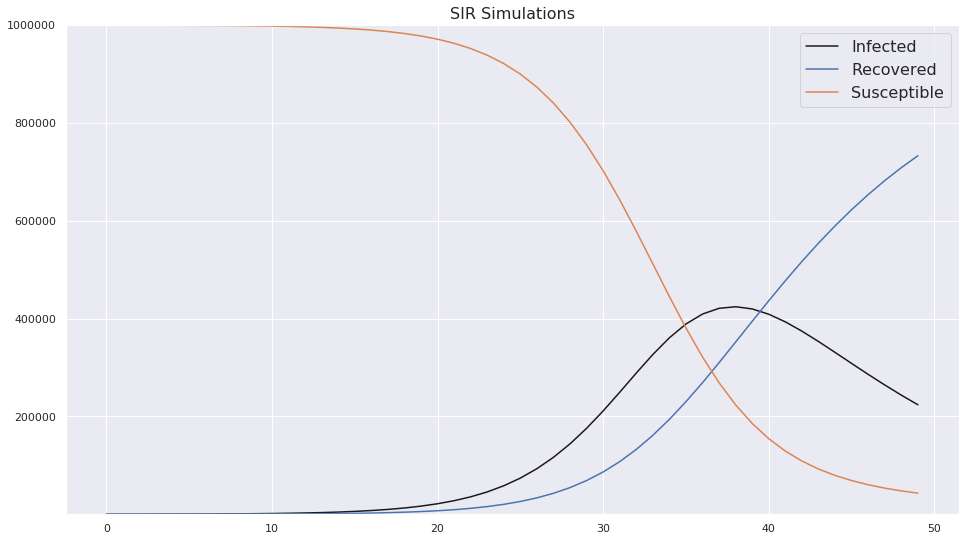

In [235]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rate.index, propagation_rate.Infected, label='Infected', color='k')
ax1.plot(propagation_rate.index, propagation_rate.Recovered, label='Recovered')
ax1.plot(propagation_rate.index, propagation_rate.Susceptible, label='Susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('SIR Simulations', size = 16)
ax1.legend(loc='best',
          prop={'size': 16})

# Fitting the parameters of SIR model

In [262]:
from scipy import optimize
from scipy import integrate

ydata = np.array(df_analyse.Italy[36:80])
time=np.arange(len(ydata))

In [270]:
I0 = ydata[0]
S0 = N0 - I0
R0 = 0
beta

0.4

In [271]:
def SIR_model(SIR,time,beta, gamma):
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I
    
    return dS_dt,dI_dt,dR_dt

In [272]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model, (S0,I0,R0), time, args=(beta,gamma))[:,1]

In [273]:
popt = [0.4,0.1]
fit_odeint(time, *popt)

array([   655.        ,    883.87462722,   1192.55445626,   1608.72718415,
         2169.57258734,   2924.92345186,   3941.40303855,   5307.77760783,
         7141.76697338,   9598.50381974,  12880.66625395,  17249.93499493,
        23038.69862452,  30659.66360389,  40609.01694948,  53456.00696248,
        69808.67925874,  90243.52213377, 115189.04211105, 144764.32348457,
       178596.78416196, 215674.88330792, 254314.39774423, 292304.10662411,
       327233.24155851, 356913.40382896, 379750.93958298, 394947.90999051,
       402494.90751413, 403006.04283722, 397486.05602483, 387108.2640611 ,
       373046.34934496, 356369.71600376, 337992.608167  , 318660.63244985,
       298959.41062889, 279334.04018901, 260112.13080876, 241526.35408523,
       223734.56774937, 206836.83311233, 190889.31539348, 175915.37966477])

In [274]:
popt,pcov = optimize.curve_fit(fit_odeint, time, ydata, maxfev=100000)
perr = np.sqrt(np.diag(pcov))

print('Standard deviation errors :', str(perr), ' start infect:', ydata[0])
print('Optimal parameters: beta = ', popt[0], ' and gamma = ', popt[1])

Standard deviation errors : [0.00591482 0.00456305]  start infect: 655
Optimal parameters: beta =  0.3849465005725332  and gamma =  0.20174599053662276


In [275]:
fitted = fit_odeint(time, *popt)

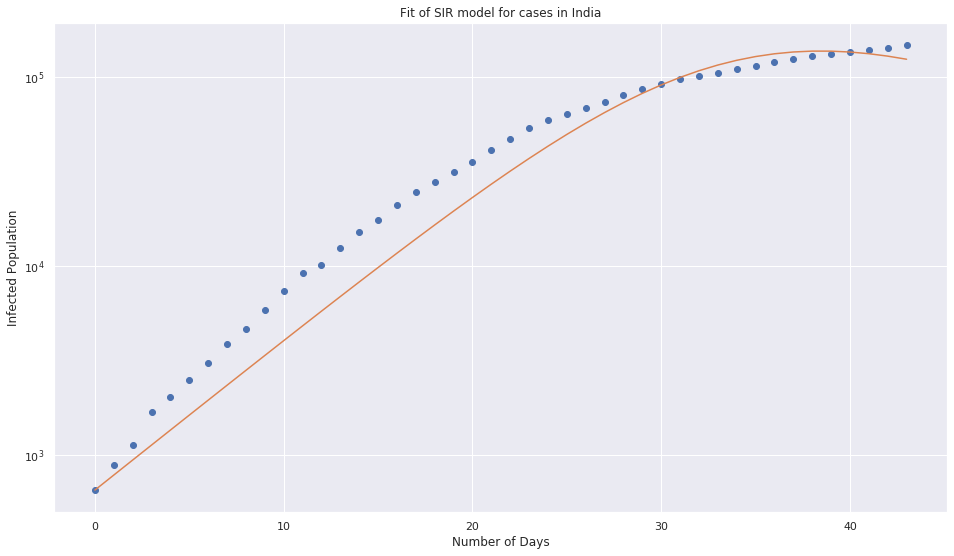

Optimal Parametes: beta =  0.3849465005725332  and gamma =  0.20174599053662276
Reproduction number, R0 :  1.908075097545268


In [276]:
plt.semilogy(time,ydata, 'o')
plt.semilogy(time, fitted)
plt.title("Fit of SIR model for cases in %s" %country)
plt.ylabel('Infected Population')
plt.xlabel('Number of Days')
plt.show()
print('Optimal Parametes: beta = ', popt[0], ' and gamma = ', popt[1])
print('Reproduction number, R0 : ', popt[0]/popt[1])

# Dynamic beta in SIR (Rate of infection)

In [244]:
t_initial = 50
t_intro_measures = 16
t_hold = 21
t_relax = 21

beta_max = popt[0]
beta_min = 0.11
gamma = popt[1]


pd_beta = np.concatenate((np.array(t_initial*[beta_max]),
                          np.linspace(beta_max, beta_min, t_intro_measures),
                          np.array(t_hold * [beta_min]),
                          np.linspace(beta_min, beta_max, t_relax)
                        ))

pd_beta

array([0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.38478765, 0.38478765, 0.38478765, 0.38478765,
       0.38478765, 0.36646848, 0.3481493 , 0.32983012, 0.31151095,
       0.29319177, 0.27487259, 0.25655341, 0.23823424, 0.21991506,
       0.20159588, 0.18327671, 0.16495753, 0.14663835, 0.12831918,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11   

In [245]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each_beta in pd_beta:
    new_delta_vector = SIR_model(SIR, time, each_beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )

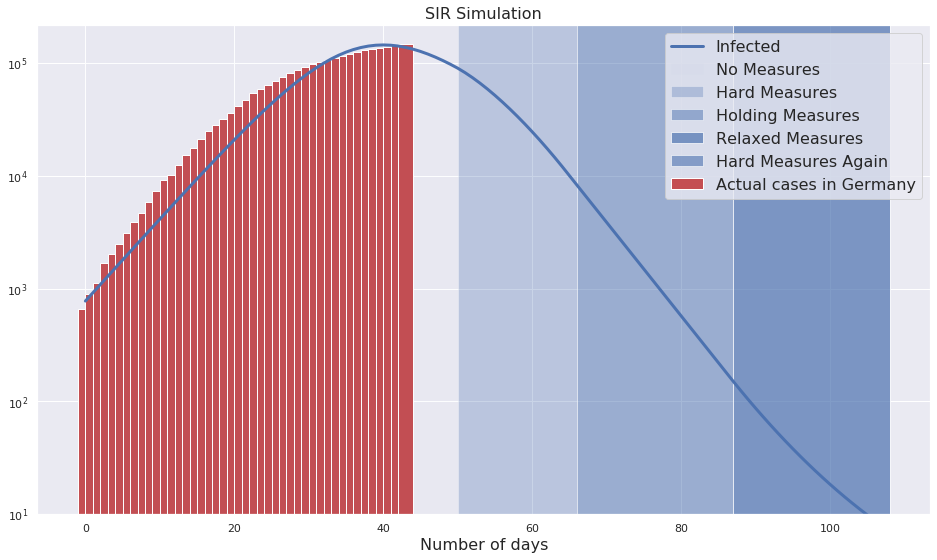

In [246]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', linewidth = 3)

ax1.bar(np.arange(len(ydata)), ydata, width=2, label = 'Actual cases in Germany', color = 'r')
t_phases = np.array([t_initial, t_intro_measures, t_hold, t_relax]).cumsum()

ax1.axvspan(0, t_phases[0], facecolor='b', alpha=0.01, label="No Measures")
ax1.axvspan(t_phases[0], t_phases[1], facecolor='b', alpha=0.3, label="Hard Measures")
ax1.axvspan(t_phases[1], t_phases[2], facecolor='b', alpha=0.5, label="Holding Measures")
ax1.axvspan(t_phases[2], t_phases[3], facecolor='b', alpha=0.7, label="Relaxed Measures")
ax1.axvspan(t_phases[3], len(propagation_rates.Infected),facecolor='b', alpha=0.6, label="Hard Measures Again")

ax1.set_ylim(10,1.5*max(propagation_rates.Infected))
#ax1.set_xlim(0,100)
ax1.set_yscale('log')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})